# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 4/28/2023
* Student Name: Rishi Sharma
* Student Net ID: bws5dk
* This URL: https://github.com/vinylrishi/Monte-Carlo-DS5100/blob/main/FinalProjectSubmission.ipynb
* GitHub Repo URL: https://github.com/vinylrishi/Monte-Carlo-DS5100

# The Monte Carlo Module

In [43]:
import pandas as pd
import numpy as np
class Die():
    """
    Creates a Die object with N sides and W weights

    Initialized:

        N: An array of faces (as strings or numbers) entered by user
        W: Weights of each face that defaults to 1.0 for each. Can be changed later by user.
        _df: A private data frame that holds each face and the coresponding weight

    Methods:

    change_weight(F,w): 
        
        This method allows the user to change the weight of a face
        
        F: Face to be changed (must be one that is in object)
        w: The desired weight of the face (input as a float)

        nothing is returned, but the data frame is altered

    
    
    roll(r): 
        
        Obtains a random sample of n rolls based on the weights of the die

        r: parameter for how many times to roll the die (defaults to 1)

        returns a list of outcomes from each roll

    
    show(): 
       
        Returns the current data frame with faces and weights being used in die
    
    """
    
    # Initializer
    def __init__(self, N):
        self.N = N
        self.W = np.ones(len(N), dtype=float)
        self._df = pd.DataFrame({'Faces':self.N, 'Weights':self.W})  
    
    def change_weight(self,F, w):
        if(F in self.N):
            try:
                self._df.loc[self._df.Faces == F, 'Weights'] = float(w)
                self.W[self._df.Faces == F] = float(w)
            except:
                print("The weight entered is not a valid number")
        else:
            print('The value entered is not a face on the object')

    def roll(self, r=1):
        sumw = sum(self._df['Weights'])
        outcomes = np.random.choice(self.N,r,p=self._df['Weights']/sumw)
        return outcomes.tolist()
    
    def show(self):
        return self._df



class Game():
    """
    A game is played by rolling one or more Die objects if the same kind, meaning they have the same faces. The weights of the Die objects can differ.

    Initialized: 

        dice: a list of similar Die objects that have already been instantiated by the user.
        _game: empty data frame that will be populated via the play method

    Methods:

    play(rolls): 

        Rolls each die in dice list the inputed number of times

        rolls: number of desired rolls per die 

        Saves a private data frame (self._game) with results of the rolls for each die

    show(shape): 
    
        Returns a data frame of the latest game's results to the user
        
        shape: the desired shape of the returned data frame (narrow or wide). Default is wide.

        Make sure the game has been played before trying to get the data frame!
    
    """
    # Initializer
    def __init__(self, dice):
        self.dice = dice
        self._game = pd.DataFrame(columns=['Die Number', 'Face Rolled'])

    def play(self, rolls = 1):
        for i in range(0,len(self.dice)):
            die_n = [i]*rolls
            results = self.dice[i].roll(rolls)
            tempdf = pd.DataFrame({'Die Number': die_n, 'Face Rolled': results})
            self._game = pd.concat([self._game,tempdf], axis = 0)
        
        self._game.index.name = 'Roll Number'
        self._game.index+=1
    
    def show(self, shape = 'wide'):
        if(shape == 'wide'):
            try:
                df = self._game.pivot_table(index = 'Roll Number', columns='Die Number', values='Face Rolled', aggfunc = lambda x: x)
                return df
            except:
                raise Exception('Make sure you have played the game!')
        elif(shape == 'narrow'):
            try:
                df = self._game.copy()
                df = df.reset_index()
                df.set_index(['Roll Number','Die Number'], inplace=True)
                return df
            except:
                raise Exception('Make sure you have played the game!')
        else:
            raise Exception('Must enter narrow or wide as options for data frame. Also, make sure you have played the game!')
        



class Analyzer():
    """
    Takes result of Game object and computes different satistics around outcomes using various methods (listed below)
    
    Initialized: 
        game: Game object passed in by user
        _game_df = private copy of narrow data frame from game results that has reset indices. Allows for easier manipulation and grouping.
        jackpots: empty dataframe that will be populated by jackpot method
        combos: empty dataframe that will be populated by combo method
        face_counts: empty dataframe that will be populated by face_counts method
        die1: sample die from game to help determine the data type of faces
        face_type: utilizes die1 to determine data type of faces on die
   

    Methods:

    face_count(): 
    
        Computes how many times each face is rolled in each roll. 
    
        Saves counts in self.face_counts.

    jackpot(): 

        Creates data frame of each roll that resulted in all die having the same face.
        Saves results in self.jackpot_df


        Returns count of rolls with all same faces to user.


    combo(): 

     Method to compute the distinct combinations of faces rolled, along with their counts.

     Stores results in self.combo_df data frame.        

    
    
    """
    # Initializer
    
    def __init__(self, game):
        self.game = game
        self._game_df = self.game.show('narrow').copy().reset_index()
        self.jackpot_df = pd.DataFrame()
        self.combo_df = pd.DataFrame()
        self.face_count_df = pd.DataFrame()
        die1 = game.dice[0].show()
        self.face_type = type(die1.iloc[:,0][0])
    
    def face_count(self): 
        fcdf = self._game_df.groupby(['Roll Number','Face Rolled']).size()
        fcdf = fcdf.to_frame('Face Counts')
        fcdf = fcdf.reset_index()
        self.face_count_df = fcdf.pivot_table(index = 'Roll Number', columns='Face Rolled', values='Face Counts', fill_value = 0)
    
    def jackpot(self):
        jpdf = self._game_df.groupby(['Roll Number','Face Rolled']).size()
        jpdf = jpdf.to_frame('Face Counts')
        jpdf = jpdf.reset_index()
        jpdf = jpdf.pivot_table(index = 'Roll Number', columns='Face Rolled', values='Face Counts', fill_value = 0)
        die_count = len(self.game.dice)
        self.jackpot_df = jpdf[jpdf.max(axis=1) == die_count]
        jackpot_count = len(self.jackpot_df.index)
        return jackpot_count
    
    def combo(self): 
        cdf =  self._game_df.groupby(['Roll Number','Face Rolled','Die Number']).size()
        cdf = cdf.to_frame('Count')
        cdf = cdf.reset_index()
        cdf = cdf.pivot_table(index = 'Roll Number', columns='Die Number', values='Face Rolled', aggfunc = lambda x: x)
        cdf = cdf.apply(lambda x: sorted(x), axis=1, result_type='expand')
        self.combo_df = cdf.value_counts().to_frame('Frequency')
        
    

# Test Module

In [47]:
import pandas as pd
import unittest

class DieTestSuite(unittest.TestCase):
    
    def test_1_change_weight(self): 
       die1 = Die([1,2,3,4,5,6])
       die1.change_weight(3,24)
       test = 24 in die1.W
       self.assertTrue(test, 'The new weight does not exist in the data frame')
    
    def test_2_roll_results(self):
       die1 = Die([1])
       die1.roll(2)
       test = die1.roll(2)
       for t in test:
           if (t ==1):
               valid = True
           else:
               valid = False

       self.assertTrue(valid, 'Two ones should be the only possible outcome')
    
    def test_3_roll_results_false(self):
       die1 = Die([1,2])
       test = die1.roll(2)
       for t in test:
           if (t ==3):
               invalid = True
           else:
               invalid = False

       self.assertFalse(invalid, 'three is not a valid face on this die')
    
    def test_4_show(self):
       die1 = Die([1,2])
       df = die1.show()
       test = df.iloc[1,0]
       self.assertEqual(test,2) 
    


class GameTestSuite(unittest.TestCase):
    def test_5_play(self):
        die1 = Die([2])
        gamer = Game([die1,die1])
        gamer.play(4)
        df = gamer.show('narrow')
        test = df.iloc[2,0]
        self.assertEqual(test,2)

    def test_6_play_false(self):
        die1 = Die([2])
        gamer = Game([die1,die1])
        gamer.play(4)
        df = gamer.show('narrow')
        test = df.iloc[2,0] == 3
        self.assertFalse(test, 'Only face value possible is 2') 

    def test_7_show_nar(self):
        die1 = Die([2])
        gamer = Game([die1,die1])
        gamer.play(4)
        df = gamer.show('narrow')
        test = len(df.index) == 8
        self.assertTrue(test, 'There should be 8 rows (4 for each die) in the narrow df')  
    
    def test_8_show_wide(self):
        die1 = Die(['H'])
        gamer = Game([die1,die1])
        gamer.play(4)
        df = gamer.show()
        test = len(df.index) == 4
        self.assertTrue(test, 'There should be 8 rows (4 for each die) in the narrow df')  



class AnalyzerTestSuite(unittest.TestCase):
    def test_9_jackpot(self):
        die1 = Die([2])
        gamer = Game([die1,die1])
        gamer.play(5)
        atest = Analyzer(gamer)
        test = atest.jackpot()
        self.assertEqual(test,5)

    def test_10_face_count(self):
        die1 = Die([2])
        gamer = Game([die1,die1])
        gamer.play(5)
        atest = Analyzer(gamer)
        atest.face_count()
        df = atest.face_count_df
        test = df.iloc[2,0] == 2
        self.assertTrue(test, 'Bot dice should have rolled into the same face')

    def test_11_combo_count(self):
        die1 = Die([2])
        gamer = Game([die1,die1])
        gamer.play(5)
        atest = Analyzer(gamer)
        atest.combo()
        df = atest.combo_df
        test = len(df.index)
        self.assertEqual(test,1)
    
    def test_12_combo_letters(self):
        die1 = Die(['H','H'])
        gamer = Game([die1,die1])
        gamer.play(5)
        atest = Analyzer(gamer)
        atest.combo()
        df = atest.combo_df
        test = len(df.index)
        self.assertEqual(test,1)

unittest.main(argv=[''], verbosity=3, exit=False)

test_10_face_count (__main__.AnalyzerTestSuite) ... ok
test_11_combo_count (__main__.AnalyzerTestSuite) ... ok
test_12_combo_letters (__main__.AnalyzerTestSuite) ... ok
test_9_jackpot (__main__.AnalyzerTestSuite) ... ok
test_1_change_weight (__main__.DieTestSuite) ... ok
test_2_roll_results (__main__.DieTestSuite) ... ok
test_3_roll_results_false (__main__.DieTestSuite) ... ok
test_4_show (__main__.DieTestSuite) ... ok
test_5_play (__main__.GameTestSuite) ... ok
test_6_play_false (__main__.GameTestSuite) ... ok
test_7_show_nar (__main__.GameTestSuite) ... ok
test_8_show_wide (__main__.GameTestSuite) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.133s

OK


# Test Results

test_10_face_count (__main__.AnalyzerTestSuite) ... ok  
test_11_combo_count (__main__.AnalyzerTestSuite) ... ok  
test_12_combo_letters (__main__.AnalyzerTestSuite) ... ok  
test_9_jackpot (__main__.AnalyzerTestSuite) ... ok  
test_1_change_weight (__main__.DieTestSuite) ... ok  
test_2_roll_results (__main__.DieTestSuite) ... ok  
test_3_roll_results_false (__main__.DieTestSuite) ... ok  
test_4_show (__main__.DieTestSuite) ... ok  
test_5_play (__main__.GameTestSuite) ... ok  
test_6_play_false (__main__.GameTestSuite) ... ok  
test_7_show_nar (__main__.GameTestSuite) ... ok  
test_8_show_wide (__main__.GameTestSuite) ... ok  

----------------------------------------------------------------------
Ran 12 tests in 0.050s

OK

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

In [48]:
import montecarlo as mc
import pandas as pd
import matplotlib.pyplot as plt


In [49]:
#Create the 2 types of coins. Change the weight of the unfair coin.
fairc = Die(['H','T'])
unfairc = Die(['H','T'])
unfairc.change_weight('H',5)


In [50]:
#Play the game 1000 times for each 3-coin group
faircgame = Game([fairc,fairc,fairc])
unfaircgame = Game([unfairc,unfairc,fairc])

faircgame.play(1000)
unfaircgame.play(1000)

In [51]:
#Analyze jackpots for both fair and unfair game
faircalyze = Analyzer(faircgame)
unfaircalyze = Analyzer(unfaircgame) 

faircjpsfreq = faircalyze.jackpot() / 1000
unfaircjpsfreq = unfaircalyze.jackpot() / 1000

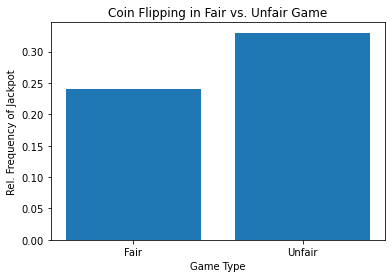

In [52]:
#Show relative frequencies of jackpots in bar chart
bardata = [faircjpsfreq,unfaircjpsfreq]
plt.bar(["Fair","Unfair"],bardata)
plt.xlabel("Game Type")
plt.ylabel("Rel. Frequency of Jackpot")
plt.title("Coin Flipping in Fair vs. Unfair Game")
plt.show()

## Scenario 2

In [53]:
#Create the 3 dice
diefair = Die([1,2,3,4,5,6])
dietype1 = Die([1,2,3,4,5,6])
dietype2 = Die([1,2,3,4,5,6])

dietype1.change_weight(6,5)
dietype2.change_weight(1,5)


In [54]:
#Play the 2 games
fair_d_game = Game([diefair,diefair,diefair,diefair,diefair])
fair_d_game.play(10000)

unfair_d_game = Game([dietype1,dietype1,dietype2,diefair,diefair])
unfair_d_game.play(10000)

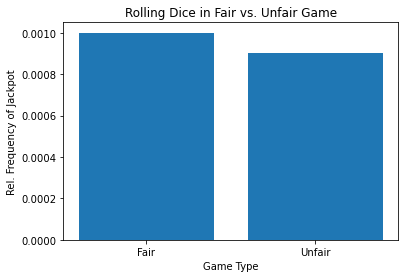

In [55]:
#Obtain the relative frequencies of jackpots for each game 
fair_d_alyze = Analyzer(fair_d_game)
unfair_d_alyze = Analyzer(unfair_d_game)

fair_d_jps_freq = fair_d_alyze.jackpot() / 10000 
unfair_d_jps_freq = unfair_d_alyze.jackpot() / 10000 

#Show relative frequency of each game in bar chart
bardata = [fair_d_jps_freq, unfair_d_jps_freq]
plt.bar(["Fair","Unfair"],bardata)
plt.xlabel("Game Type")
plt.ylabel("Rel. Frequency of Jackpot")
plt.title("Rolling Dice in Fair vs. Unfair Game")
plt.show()


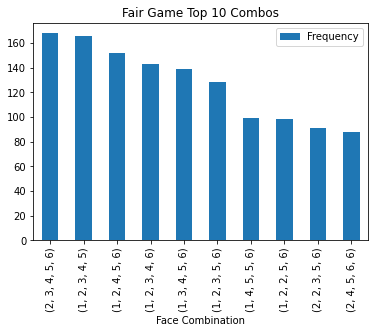

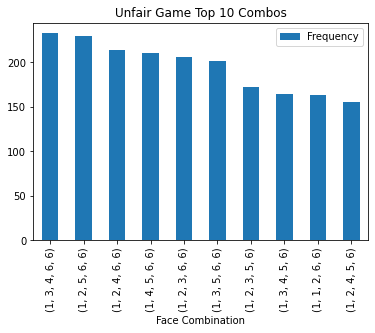

In [56]:
#Obtain top 10 combos for fair and unfair game
fair_d_alyze.combo()
unfair_d_alyze.combo()

top10_fair = fair_d_alyze.combo_df.head(10)
top10_unfair = unfair_d_alyze.combo_df.head(10)

#Plot top10 fair game face combos
top10_fair.plot(y='Frequency', kind='bar')
plt.title('Fair Game Top 10 Combos')	
plt.xlabel("Face Combination")
plt.show()

#plot top10 unfair game face combos
top10_unfair.plot(y='Frequency', kind='bar')
plt.title('Unfair Game Top 10 Combos')
plt.xlabel("Face Combination")
plt.show()


## Scenario 3

In [57]:
# Import txt file with letters and weights
alphabet=pd.read_csv('letter_weights.txt', sep=' ', header=None, names=['Letter', 'Weights'])
alphabet

# Create lists of letters and weights too be faces and weights of die, respectively
letters = list(alphabet['Letter'])
weights = list(alphabet['Weights'])

# Create Die of letters
letter_die = Die(letters)

# For each letter in the alphabet, apply the weight to corresponding letter
for i in range(0,26):
    letter_die.change_weight(alphabet['Letter'][i],alphabet['Weights'][i])



In [58]:
# Create and play the game 1000 times
letter_game = Game([letter_die,letter_die,letter_die,letter_die,letter_die])

letter_game.play(1000)


In [59]:
# Analyze the game and get a data frame of unique combos
letter_alyze = Analyzer(letter_game)

letter_alyze.combo()

letter_combo_df = letter_alyze.combo_df

#Code for unique combos data frame is at end to not disrupt the flow of this block.

# Relative frequency of real words
print(4/10000)

#Relative frequency of these words is .0004


0.0004


The below code will display a very long data frame with all combos. 

There are about 4 combos that resemble a real English word in this data frame (Ex, "DOORT" is like "DOOR"),  
however, this is a nearly uncountable manual task for roughly 970 unique combos, especially as they change  
with every run of the code file.  

The relative frequency based on the eye test of the data frame was roughly .0004

In [60]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth',1)
display(letter_combo_df)

Frequency
0 1 2 3 4           
A A E E T  3        
C E L O T  2        
E I O O R  2        
A N P R U  2        
B E E N T  2        
A N N R R  2        
  A E I O  2        
  I I N U  2        
  D L R T  2        
E G I P T  2        
  K M O T  2        
  O O T Y  2        
A E I L P  2        
        N  2        
E E I I N  2        
C L N N S  2        
A A I O R  2        
D E I O R  2        
I R T U Y  2        
A E L N S  2        
  H O P T  2        
  C I O P  2        
  I O V W  2        
  E F R T  2        
  N R T T  2        
G H I R R  2        
E E E L N  2        
A B I L S  2        
D I N O T  2        
C C E F U  2        
A E P S T  2        
E I I N P  2        
B L N O R  2        
E M P R S  2        
A B E N R  2        
  I N R T  1        
  L M R R  1        
    L M P  1        
      O T  1        
  I O O Y  1        
      R T  1        
      T Y  1        
  K O O R  1        
    M R S  1        
  J N S T  1        
  I S U U  1        
  L M S S  1        
  I R S T  1        
  M N O O  1        
  L N R T  1        
    O O T  1        
  S T X Y  1        
  R R R T  1        
  O P S W  1        
        U  1        
        T  1        
      R S  1        
    O R U  1        
  N T U U  1        
    R T X  1        
      S T  1        
      R W  1        
    O T U  1        
      R T  1        
    N P R  1        
  M R R T  1        
    N Y Z  1        
      S V  1        
      R S  1        
  I N N O  1        
  L S S U  1        
    P T Y  1        
    O S U  1        
      R Y  1        
  I N O X  1        
    L P R  1        
    N N N  1        
  G O O U  1        
    N T Y  1        
      O R  1        
    L R R  1        
    I R Z  1        
        T  1        
      N S  1        
      M U  1        
      L N  1        
      I T  1        
    H L U  1        
  F O R R  1        
      O S  1        
    L N O  1        
    I L M  1        
    H P V  1        
  E S W Y  1        
    R T W  1        
      S U  1        
      R W  1        
        T  1        
    P R T  1        
    O T W  1        
      S Y  1        
      R W  1        
        S  1        
  G O O S  1        
    P P R  1        
  I M T W  1        
  G R W W  1        
  I M R S  1        
      N O  1        
    L R T  1        
B B D I U  1        
A I L O T  1        
      N S  1        
        O  1        
    K N T  1        
      L O  1        
    I U V  1        
      O V  1        
        S  1        
  H R U V  1        
    P T U  1        
        T  1        
      S S  1        
    O U Y  1        
    N O R  1        
    M P S  1        
    L R S  1        
    I R T  1        
      O Y  1        
      L T  1        
    H N S  1        
      M O  1        
B B D I T  1        
  C L R R  1        
    E I R  1        
C D E L R  1        
    N T U  1        
    L R T  1        
        S  1        
      O Y  1        
        T  1        
        O  1        
    I T V  1        
      N R  1        
    G N O  1        
      I P  1        
    F S T  1        
    E O T  1        
      I N  1        
  E E E N  1        
  D E G Y  1        
        X  1        
      E O  1        
        I  1        
  C P U U  1        
    N R T  1        
        R  1        
      N O  1        
    M O P  1        
    L R S  1        
      O O  1        
      L O  1        
  D N T Y  1        
  E E G N  1        
  C I R R  1        
  E H L P  1        
    L L L  1        
    I V Z  1        
      O U  1        
        S  1        
      M S  1        
        O  1        
        N  1        
      L S  1        
      I L  1        
    H O U  1        
        P  1        
      N R  1        
      L L  1        
    E H V  1        
    H I R  1        
    G I T  1        
        L  1        
    F O S  1        
      F T  1        
    E T V  1        
      R U  1        
      O Y  1        
        S  1        


# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [61]:
!ls -lRF -o

.:
total 616
-rw-r--r-- 1 bws5dk 273513 Apr 28 19:48 FinalProjectSubmission.ipynb
-rw-r--r-- 1 bws5dk    259 Apr 28 18:53 letter_weights.txt
-rw-r--r-- 1 bws5dk   1067 Apr 28 18:49 LICENSE
drwxr-sr-x 4 bws5dk   2048 Apr 28 19:48 montecarlo/
-rw-r--r-- 1 bws5dk 308869 Apr 28 18:53 montecarlo_demo.ipynb
drwxr-sr-x 2 bws5dk   2048 Apr 28 19:38 montecarlo.egg-info/
-rw-r--r-- 1 bws5dk    730 Apr 28 18:53 montecarlo-test-results.txt
-rw-r--r-- 1 bws5dk   3441 Apr 28 18:53 montecarlo_tests.py
-rw-r--r-- 1 bws5dk    166 Apr 28 18:49 README.md
-rw-r--r-- 1 bws5dk    315 Apr 28 18:53 setup.py

./montecarlo:
total 20
-rw-r--r-- 1 bws5dk    0 Apr 28 18:53 __init__.py
-rw-r--r-- 1 bws5dk 7133 Apr 28 19:48 montecarlo.py
drwxr-sr-x 2 bws5dk  512 Apr 28 19:12 __pycache__/

./montecarlo/__pycache__:
total 4
-rw-r--r-- 1 bws5dk 179 Apr 28 19:12 __init__.cpython-38.pyc

./montecarlo.egg-info:
total 16
-rw-r--r-- 1 bws5dk   1 Apr 28 19:38 dependency_links.txt
-rw-r--r-- 1 bws5dk 253 Apr 28 19:38 PKG-INFO

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [62]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/bws5dk/Documents/MSDS/DS5100/Monte-Carlo-DS5100
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 0.1
    Uninstalling montecarlo-0.1:
      Successfully uninstalled montecarlo-0.1
  Running setup.py develop for montecarlo


Test Install in Rivanna  

bash-4.2$ pwd /home/bws5dk/Documents/MSDS/DS5100/Monte-Carlo-DS5100   

bash-4.2$pip install -e .  
Obtaining file:///sfs/qumulo/qhome/bws5dk/Documents/MSDS/DS5100/Monte-Carlo-DS5100  
Installing collected packages: montecarlo  
  Running setup.py develop for montecarlo  
Successfully installed montecarlo